K-Means cluster sizes:
 kmeans_cluster
1    18
0    17
2    15
Name: count, dtype: int64


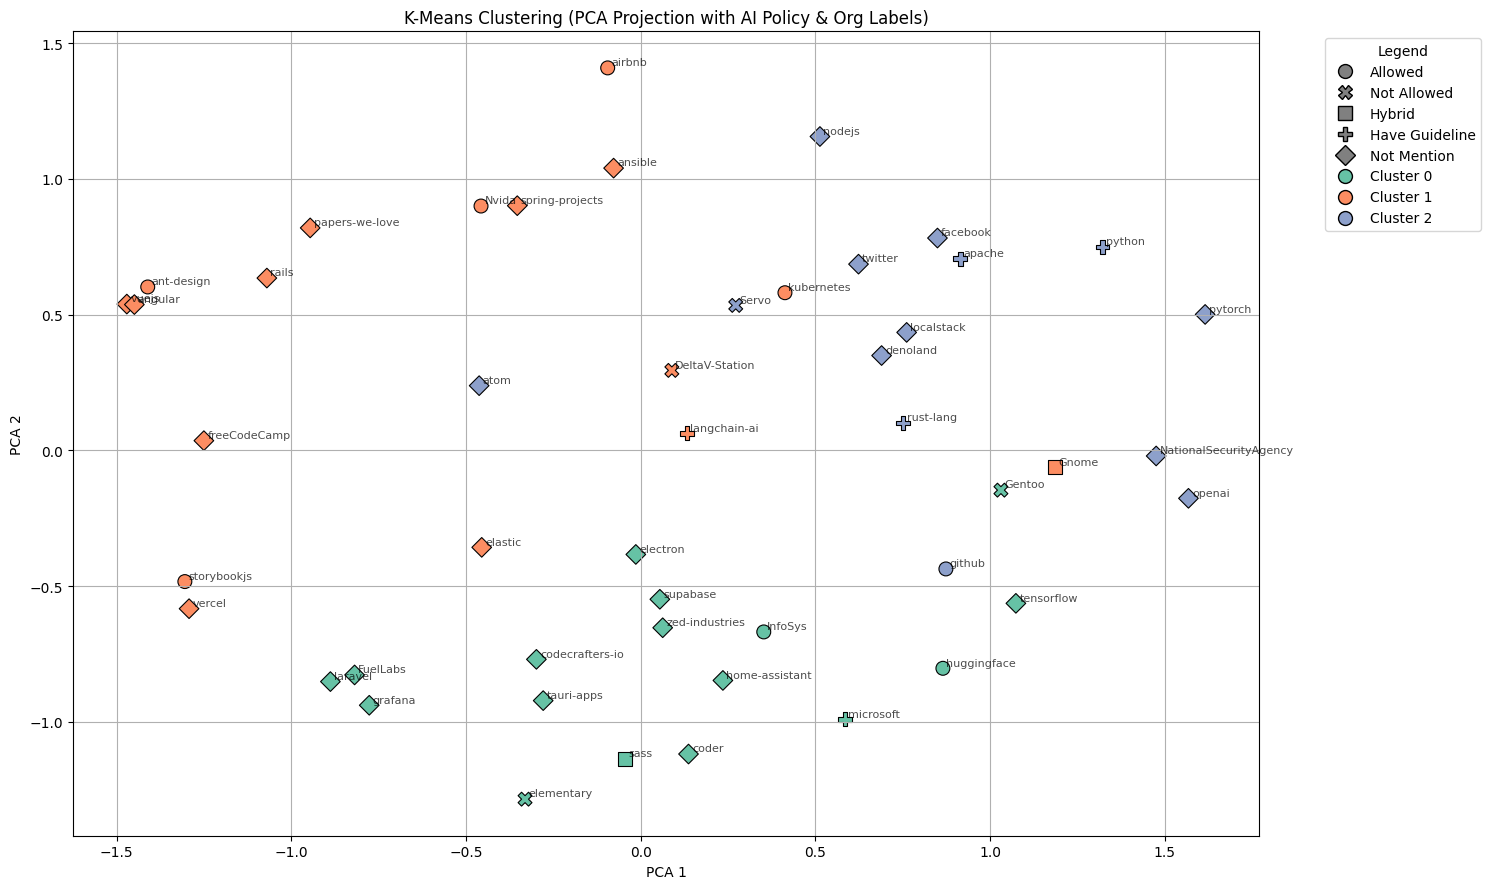

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/content/drive/MyDrive/SET SEMINAR/Extended_AI_Policy_and_GitHub_Org_Overview.csv")

# Preprocess 'languages' and 'topics'
df['languages'] = df['languages'].fillna('').apply(lambda x: [i.strip() for i in str(x).split(',') if i])
df['topics'] = df['topics'].fillna('').apply(lambda x: [i.strip() for i in str(x).split(',') if i])


# One-hot encode
mlb_lang = MultiLabelBinarizer()
mlb_topic = MultiLabelBinarizer()
lang_df = pd.DataFrame(mlb_lang.fit_transform(df["languages"]), columns=[f"lang_{c}" for c in mlb_lang.classes_])
topic_df = pd.DataFrame(mlb_topic.fit_transform(df["topics"]), columns=[f"topic_{c}" for c in mlb_topic.classes_])
features = pd.concat([lang_df, topic_df], axis=1)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["kmeans_cluster"] = kmeans.fit_predict(features)

# Print cluster sizes
print("K-Means cluster sizes:\n", df["kmeans_cluster"].value_counts())

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
df["pca1"] = pca_result[:, 0]
df["pca2"] = pca_result[:, 1]

# Define marker shapes for AI Policy
marker_styles = {
    "Allowed": "o",
    "Not Allowed": "X",
    "Hybrid": "s",
    "Have Guideline": "P",
    "Not Mention": "D"
}

# Plot with different markers and cluster colors
# Plot with different markers and cluster colors
plt.figure(figsize=(15, 9))
for policy, marker in marker_styles.items():
    subset = df[df["AI Policy"] == policy]
    scatter = sns.scatterplot(
        data=subset,
        x="pca1",
        y="pca2",
        hue="kmeans_cluster",
        palette="Set2",
        style="AI Policy",
        markers=marker_styles,
        s=100,
        marker=marker,
        edgecolor="black",
        legend=False
    )

    # Add org names as text labels
    for _, row in subset.iterrows():
        plt.text(row["pca1"] + 0.01, row["pca2"] + 0.01, row["org"], fontsize=8, alpha=0.7)

# Custom legends
from matplotlib.lines import Line2D
ai_legend = [Line2D([0], [0], marker=marker_styles[p], color='w', label=p,
                    markerfacecolor='gray', markersize=10, markeredgecolor='black')
             for p in marker_styles]

cluster_legend = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {c}',
                         markerfacecolor=col, markersize=10, markeredgecolor='black')
                  for c, col in zip(sorted(df['kmeans_cluster'].unique()), sns.color_palette('Set2', n_colors=3))]

plt.legend(handles=ai_legend + cluster_legend, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("K-Means Clustering (PCA Projection with AI Policy & Org Labels)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Export with AI Policy
df_export = df[["org", "AI Policy", "languages", "topics", "kmeans_cluster"]]
df_export.to_csv("/content/drive/MyDrive/SET SEMINAR/Clustered_Orgs.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

# === CONFIG ===
BASE_PATH = "/content/drive/MyDrive/SET SEMINAR"
CLUSTER_FILE = os.path.join(BASE_PATH, "Clustered_Orgs.csv")
INTERVENTION_DATE = pd.to_datetime("2022-01-01")
RESULTS_OUTPUT = os.path.join(BASE_PATH, "its_summary_results.csv")

# === LOAD CLUSTER INFO ===
df_clusters = pd.read_csv(CLUSTER_FILE)
ai_policy_map = {
    "Allowed": "LLM_Positive",
    "Hybrid": "LLM_Negative",
    "Not Allowed": "LLM_Negative",
    "Not Mention": "Neutral",
    "Have Guideline": "LLM_Positive",
}
df_clusters["PolicyGroup"] = df_clusters["AI Policy"].map(ai_policy_map)

# === DEFINE TOP LANGUAGES PER CLUSTER ===
cluster_top_langs = {
   0: ['TypeScript', 'JavaScript', 'Python', 'C++', 'C'], 1: ['JavaScript', 'HTML', 'CSS', 'TypeScript', 'Python'], 2: ['C', 'C++', 'Python', 'HTML', 'JavaScript']
}

# === ITS ANALYSIS FUNCTION ===
def run_its_analysis(data, language, policy_group, cluster_id, results_list):
    data["month"] = data["created_at"].dt.to_period("M")
    lang_repos = data[data["language"] == language].groupby("month").size().rename("lang_repos")
    total_repos = data.groupby("month").size().rename("total_repos")

    df = pd.concat([lang_repos, total_repos], axis=1).fillna(0)
    df.index = df.index.to_timestamp()
    df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq="MS"), fill_value=0)
    df.index.name = "month"
    df = df.reset_index()

    df["time"] = np.arange(len(df))
    df["llm"] = (df["month"] >= INTERVENTION_DATE).astype(int)
    df["time_after_llm"] = df.apply(
        lambda row: row["time"] - df[df["llm"] == 1]["time"].min() if row["llm"] == 1 else 0,
        axis=1
    )
    df["lang_ratio"] = df["lang_repos"] / (df["total_repos"] + 1e-6)

    X = df[["time", "llm", "time_after_llm"]]
    X = sm.add_constant(X)
    y = df["lang_ratio"]

    try:
        model = sm.OLS(y, X).fit()
        results_list.append({
            "cluster": cluster_id,
            "language": language,
            "policy_group": policy_group,
            "intercept": model.params["const"],
            "trend_before": model.params["time"],
            "level_change": model.params["llm"],
            "slope_change": model.params["time_after_llm"],
            "p_level": model.pvalues["llm"],
            "p_slope": model.pvalues["time_after_llm"],
            "r_squared": model.rsquared
        })
    except:
        print(f"[Skipped] ITS failed for Cluster {cluster_id}, {policy_group}, {language}")

# === MAIN AGGREGATION PIPELINE ===
its_results = []

for cluster_id in [0, 1, 2]:
    top_langs = cluster_top_langs[cluster_id]
    orgs_in_cluster = df_clusters[df_clusters["kmeans_cluster"] == cluster_id]

    for policy_group in ["LLM_Positive", "LLM_Negative", "Neutral"]:
        orgs = orgs_in_cluster[orgs_in_cluster["PolicyGroup"] == policy_group]["org"]

        org_dataframes = []
        for org in orgs:
            file_path = os.path.join(BASE_PATH, f"{org}.csv")
            if os.path.exists(file_path):
                try:
                    df_org = pd.read_csv(file_path, parse_dates=["created_at"])
                    df_org["org"] = org
                    org_dataframes.append(df_org)
                except:
                    print(f"[Error] Reading file for {org}")
            else:
                print(f"[Missing] {file_path}")

        if not org_dataframes:
            continue

        df_meta = pd.concat(org_dataframes, ignore_index=True)

        for lang in top_langs:
            run_its_analysis(df_meta.copy(), lang, policy_group, cluster_id, its_results)

# === SAVE RESULTS ===
df_results = pd.DataFrame(its_results)
df_results.to_csv(RESULTS_OUTPUT, index=False)
print(f"\n✅ ITS summary results saved to: {RESULTS_OUTPUT}")
display(df_results.head())

<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index repr

[Skipped] ITS failed for Cluster 1, LLM_Negative, JavaScript
[Skipped] ITS failed for Cluster 1, LLM_Negative, HTML
[Skipped] ITS failed for Cluster 1, LLM_Negative, CSS
[Skipped] ITS failed for Cluster 1, LLM_Negative, TypeScript
[Skipped] ITS failed for Cluster 1, LLM_Negative, Python


<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index repr


✅ ITS summary results saved to: /content/drive/MyDrive/SET SEMINAR/its_summary_results.csv


<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
<ipython-input-52-bde0dd118ef5>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")


,cluster,language,policy_group,intercept,trend_before,level_change,slope_change,p_level,p_slope,r_squared
0,0,TypeScript,LLM_Positive,2.763899e-02,7.010549e-05,-0.025513,0.001014,0.630920,0.596363,0.003335
1,0,JavaScript,LLM_Positive,1.498501e-03,1.314474e-04,0.018145,-0.000043,0.468541,0.961626,0.034765
2,0,Python,LLM_Positive,1.798201e-02,3.811971e-04,0.037620,0.008117,0.609627,0.002721,0.301302
3,0,C++,LLM_Positive,1.200309e-17,-2.230469e-19,-0.003022,0.000413,0.356968,0.000649,0.179913
4,0,C,LLM_Positive,5.517629e-18,-1.075455e-19,-0.001442,0.000124,0.367436,0.032514,0.060032


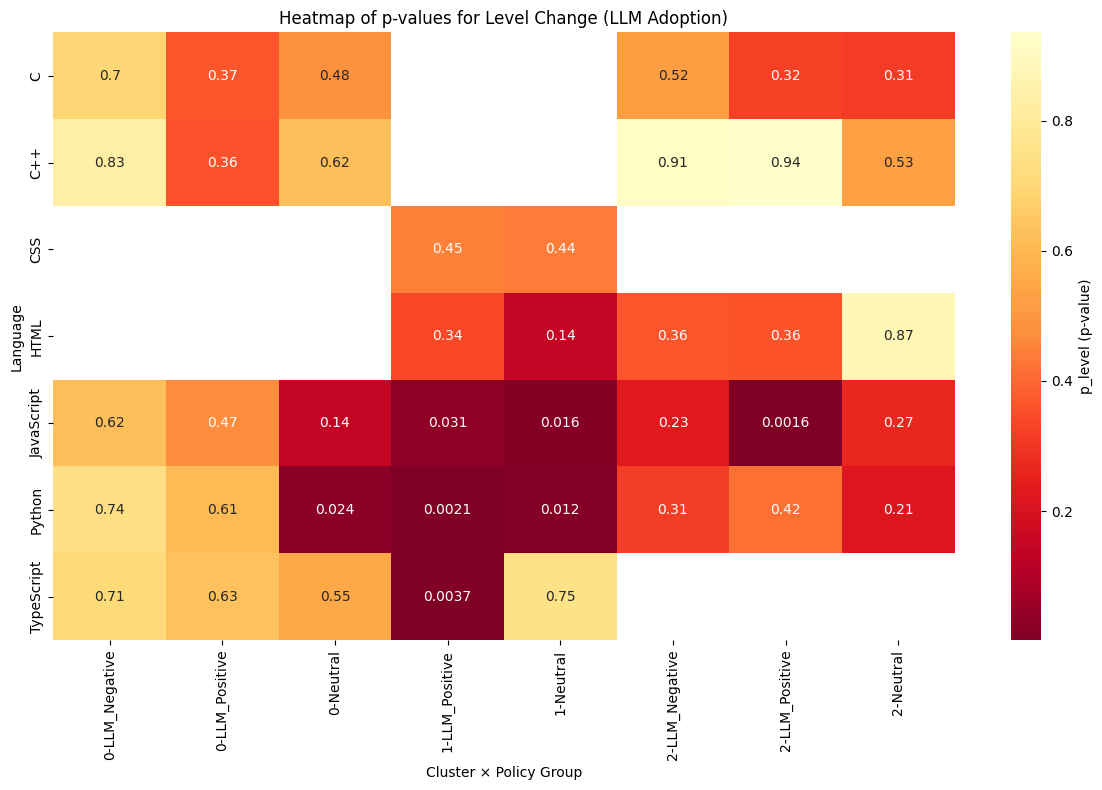

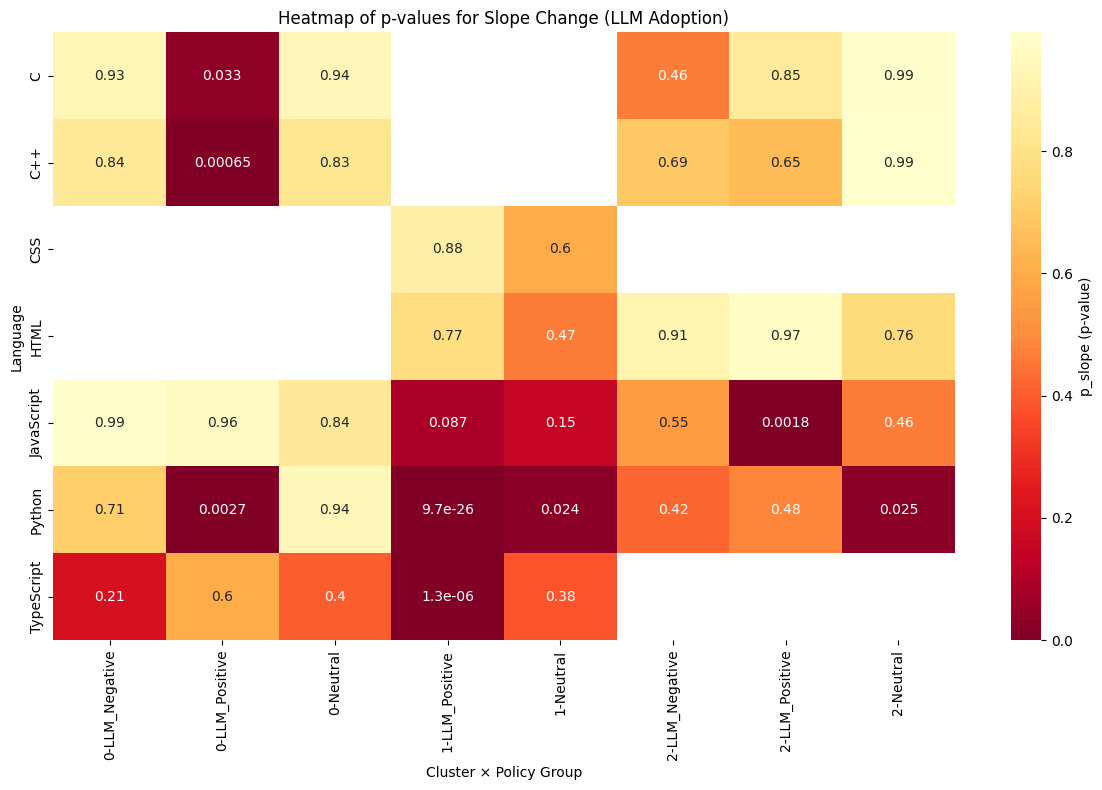

In [ ]:
# Re-import necessary libraries due to kernel reset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reload the ITS results CSV file
BASE_PATH = "/content/drive/MyDrive/SET SEMINAR"
CLUSTER_FILE = os.path.join(BASE_PATH, "Clustered_Orgs.csv")
INTERVENTION_DATE = pd.to_datetime("2022-01-01")
RESULTS_OUTPUT = os.path.join(BASE_PATH, "its_summary_results.csv")
file_path = "/content/drive/MyDrive/SET SEMINAR/its_summary_results.csv"
its_results_df = pd.read_csv(file_path)

# Convert p-values to numeric if needed
its_results_df['p_level'] = pd.to_numeric(its_results_df['p_level'], errors='coerce')
its_results_df['p_slope'] = pd.to_numeric(its_results_df['p_slope'], errors='coerce')

# Create a pivot table for heatmaps
def create_significance_heatmap(data, value_col, title, filename):
    pivot_df = data.pivot_table(
        index="language",
        columns=["cluster", "policy_group"],
        values=value_col,
        aggfunc="min"
    )

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot_df,
        cmap="YlOrRd_r",  # Darker color = stronger significance
        annot=True,
        fmt=".2g",
        cbar_kws={"label": f"{value_col} (p-value)"}
    )
    plt.title(title)
    plt.ylabel("Language")
    plt.xlabel("Cluster × Policy Group")
    plt.tight_layout()
    plt.savefig(f"{BASE_PATH}/{filename}", dpi=300)  # Save as PNG
    plt.show()
create_significance_heatmap(its_results_df, "p_level", "Heatmap of p-values for Level Change (LLM Adoption)", "level_change_heatmap.png")
create_significance_heatmap(its_results_df, "p_slope", "Heatmap of p-values for Slope Change (LLM Adoption)", "slope_change_heatmap.png")


In [ ]:
import pandas as pd
from ast import literal_eval
from collections import Counter

# Load clustered orgs file
clustered_orgs_path = "/content/drive/MyDrive/SET SEMINAR/Clustered_Orgs.csv"
df_clusters = pd.read_csv(clustered_orgs_path)

# Convert stringified lists to actual Python lists
df_clusters['languages'] = df_clusters['languages'].apply(literal_eval)
df_clusters['topics'] = df_clusters['topics'].apply(literal_eval)

# Initialize dicts
cluster_top_langs = {}
cluster_top_topics = {}

# Process each cluster
for cluster_id, group in df_clusters.groupby("kmeans_cluster"):
    # Top languages
    all_languages = [lang for sublist in group["languages"] for lang in sublist]
    top_5_langs = [lang for lang, _ in Counter(all_languages).most_common(5)]
    cluster_top_langs[cluster_id] = top_5_langs

    # Top topics
    all_topics = [topic for sublist in group["topics"] for topic in sublist]
    top_5_topics = [topic for topic, _ in Counter(all_topics).most_common(5)]
    cluster_top_topics[cluster_id] = top_5_topics

# Outpu
cluster_top_langs

{0: ['TypeScript', 'JavaScript', 'Python', 'C++', 'C'],
 1: ['JavaScript', 'HTML', 'CSS', 'TypeScript', 'Python'],
 2: ['C', 'C++', 'Python', 'HTML', 'JavaScript']}

In [ ]:
cluster_top_langs

{0: ['TypeScript', 'JavaScript', 'Python', 'C++', 'C'],
 1: ['JavaScript', 'HTML', 'CSS', 'TypeScript', 'Python'],
 2: ['C', 'C++', 'Python', 'HTML', 'JavaScript']}